In [48]:
from torch.utils.data import Dataset
import numpy as np
import torch
from PIL import Image
import pickle
import os
import matplotlib.pyplot as plt
from torchvision import transforms as T
import pandas as pd
import rasterio
import math
from os.path import join as pjoin
from collections import OrderedDict
import torch.nn.functional as F
import ml_collections
import torch.backends.cudnn as cudnn
import random
import torch.nn as nn
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [49]:
ROOT = "data/"
WORKDIR = "."

# 저장 이름
save_name = 'base_line'

N_FILTERS = 16 # 필터수 지정
N_CHANNELS = 3 # channel 지정
IMAGE_SIZE = (256, 256) # 이미지 크기 지정
MODEL_NAME = 'TransUNet' # 모델 이름

# 가중치 저장 위치
OUTPUT_DIR = './train_output/'

CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, save_name)

# 최종 가중치 저장 이름
FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, save_name)

# Pytorch의 Dataset 클래스를 상속받아 pytorch의 DataLoader를 활용하여 학습

In [50]:
class Spark(Dataset):
    MAX_PIXEL_VALUE = 65535 # 이미지 정규화를 위한 픽셀 최대값

    def __init__(self, root = ROOT, train = True, transform = None):
        super(Spark, self).__init__()
        self.transform = transform
        self.train = train
        self.root = root
        if train:
            self.data = pd.read_csv(os.path.abspath(os.path.join(root, "train_meta.csv")))
        else:
            self.data = pd.read_csv(os.path.abspath(os.path.join(root, "test_meta.csv")))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_dir, mask_dir = self.data[self.data.columns]
        img_name, mask_name = self.data[img_dir], self.data[mask_dir]

        img = rasterio.open(f"{self.root}{img_dir}/{img_name[index]}").read((7,6,2)).transpose((1, 2, 0))
        img = np.float32(img) / Spark.MAX_PIXEL_VALUE
        
        mask = rasterio.open(f"{self.root}{mask_dir}/{mask_name[index]}").read().transpose((1, 2, 0))
        mask = np.float32(mask)

        if self.transform is not None:
            augmentation = self.transform(image = img, mask = mask)
            img = augmentation['image']
            mask = augmentation['mask']
        
        return img, mask


# TransUNet 구현 코드 (https://github.com/Beckschen/TransUNet 참고)

In [51]:
def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_testing():
    """Returns a minimal configuration for testing."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 1
    config.transformer.num_heads = 1
    config.transformer.num_layers = 1
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config


def get_b32_config():
    """Returns the ViT-B/32 configuration."""
    config = get_b16_config()
    config.patches.size = (32, 32)
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_32.npz'
    return config


def get_l16_config():
    """Returns the ViT-L/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1024
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 4096
    config.transformer.num_heads = 16
    config.transformer.num_layers = 24
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.representation_size = None

    # custom
    config.classifier = 'seg'
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-L_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_r50_l16_config():
    """Returns the Resnet50 + ViT-L/16 configuration. customized """
    config = get_l16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.resnet_pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_l32_config():
    """Returns the ViT-L/32 configuration."""
    config = get_l16_config()
    config.patches.size = (32, 32)
    return config


def get_h14_config():
    """Returns the ViT-L/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (14, 14)})
    config.hidden_size = 1280
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 5120
    config.transformer.num_heads = 16
    config.transformer.num_layers = 32
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None

    return config


In [52]:
def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)


class PreActBottleneck(nn.Module):
    """Pre-activation (v2) bottleneck block.
    """

    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1!!
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel")], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel")], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel")], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale")])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias")])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale")])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias")])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale")])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias")])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel")], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale")])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias")])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

class ResNetV2(nn.Module):
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
        for i in range(len(self.body)-1):
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]

In [53]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math

from os.path import join as pjoin

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

logger = logging.getLogger(__name__)


ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)

        if config.patches.get("grid") is not None:   # ResNet
            grid_size = config.patches["grid"]
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])  
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])


    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features


class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))


class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights


class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
        return encoded, attn_weights, features


class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            use_batchnorm=True,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)


class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(
            config.hidden_size,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True,
        )
        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4-self.config.n_skip):  # re-select the skip channels according to n_skip
                skip_channels[3-i]=0

        else:
            skip_channels=[0,0,0,0]

        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config, img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(
            in_channels=config['decoder_channels'][-1],
            out_channels=config['n_classes'],
            kernel_size=3,
        )
        self.config = config

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        x, attn_weights, features = self.transformer(x)  # (B, n_patch, hidden)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits

    def load_from(self, weights):
        with torch.no_grad():

            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)

CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'ViT-B_32': get_b32_config(),
    'ViT-L_16': get_l16_config(),
    'ViT-L_32': get_l32_config(),
    'ViT-H_14': get_h14_config(),
    'R50-ViT-B_16': get_r50_b16_config(),
    'R50-ViT-L_16': get_r50_l16_config(),
    'testing': get_testing(),
}


# 모델 가중치 저장

In [54]:
def save(net, optimizer, epoch, acc, fileName = MODEL_NAME):
    root = OUTPUT_DIR

    # 저장 폴더 없으면 생성
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best': acc
            }, os.path.abspath(os.path.join(root, fileName + ".pth")))

def load(fileName):
    try:
        exp_dir = OUTPUT_DIR
        file_dir = os.path.abspath(os.path.join(exp_dir, fileName + ".pth"))

        state_dict = torch.load(file_dir)

        epoch = state_dict["epoch"]
        best = state_dict["best"]
        model_state_dict = state_dict["model_state_dict"]
        optimizer_state_dict = state_dict["optimizer_state_dict"]

        return epoch, best, model_state_dict, optimizer_state_dict
    except:
        return -1, float("-inf"), None, None

# 학습에 필요한 loss 함수 등을 정의

In [55]:
# 이미지를 보여주기 위한 헬퍼(helper) 함수
# (아래 `plot_classes_preds` 함수에서 사용)
def matplotlib_imshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim = 0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap = "Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
import numpy as np
import torch

# 픽셀 정확도를 계산 metric
def pixel_accuracy(y_true, y_pred):
    sum_n = np.sum(np.logical_and(y_pred, y_true))
    sum_t = np.sum(y_true)
 
    if (sum_t == 0):
        pixel_accuracy = 0
    else:
        pixel_accuracy = sum_n / sum_t
    return pixel_accuracy 

def diceWithLogit(x: torch.Tensor, y: torch.Tensor, eps = 1e-8):
    x = torch.sigmoid(x)
    GT = y.sum(dim = (2, 3))
    PD = x.sum(dim = (2, 3))
    IT = (y * x).sum(dim = (2, 3)) + eps
    Union = GT + PD + eps
    
    dc = ((2 * IT) / Union)
    return dc.mean()

class BCELoss2d:
    def __init__(self, weight):
        self.weight = weight
    
    def __call__(self, x, y):
        x = torch.sigmoid(x)
        eps = 1e-8
        l = - self.weight * ((y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps)))

        return l.mean()

class DiffIoU:
    def __init__(self, threshole = 0.5, eps = 1e-8) -> None:
        self.threshold = threshole
        self.eps = eps

    def __call__(self, x, y):
        x = torch.sigmoid(x)
        x = (x >= self.threshold)
        union = (x + y).sum(dim = (-2, -1)) + self.eps
        it = (x * y).sum(dim = (-2, -1))
        union = union - it

        area1 = union
        u = it / union
        
        x = 1 - 1 * x
        y = 1 - y
        union = (x + y).sum(dim = (-2, -1)) + self.eps
        it = (x * y).sum(dim = (-2, -1))
        union = union - it

        area2 = union
        v = it / union

        return ((area2 * u + area1 * v) / (area1 + area2)).mean()

class BCEDiffIoU:
    def __init__(self, threshold, weight = 1, eps = 1e-8) -> None:
        self.threshold = threshold
        self.weight = weight
        self.eps = eps
        self.BCELoss2d = BCELoss2d(self.weight)
        self.DiffIoU = DiffIoU(self.threshold, self.eps)

    def __call__(self, x, y):
        bce_loss = self.BCELoss2d(x, y)
        diffIoU = self.DiffIoU(x, y)

        return bce_loss + 1 - diffIoU
    
    def eval(self, x, y):
        return self.DiffIoU(x, y)

class mIoU:
    def __init__(self, threshold = 0.5, eps = 1e-8):
        self.threshold = threshold
        self.eps = eps
        self.IoU = IoU(self.threshold, self.eps)
    
    def __call__(self, x, y):
        u = self.IoU(x, y)
        v = self.IoU(-1 * x, 1 - y)

        return (u + v) / 2

class IoU:
    def __init__(self, threshold = 0.5, eps = 1e-8):
        self.threshold = threshold
        self.eps = eps

    def __call__(self, x, y):
        x = torch.sigmoid(x)
        x = (x >= self.threshold)
        union = (x + y).sum(dim = (-2, -1)) + self.eps
        it = (x * y).sum(dim = (-2, -1))
        union = union - it

        return (it / union).mean()

class SoftmIoU:
    def __init__(self, eps = 1e-8):
        self.eps = eps
        self.softIoU = SoftIoU(self.eps)

    def __call__(self, x, y):
        u = self.softIoU(x, y)
        v = self.softIoU(-1 * x, 1 - y)

        return (u + v) / 2

class SoftIoU:
    def __init__(self, eps = 1e-8):
        self.eps = eps

    def __call__(x, y):
        x = torch.sigmoid(x)
        area = y.sum(dim = (-2, -1))
        it = (x * y).sum(dim = (-2, -1))

        return (it / area).mean()

class BCEsoftmIoULoss:
    def __init__(self, weight) -> None:
        self.weight = weight
        self.BCELoss2d = BCELoss2d(self.weight)
        self.soft_mIoU = SoftmIoU()

    def __call__(self, x, y):
        bce_loss = self.BCELoss2d(x, y)
        miou = self.soft_mIoU(x, y)

        return bce_loss + 1 - miou
    
    def eval(self, x, y):
        return self.soft_mIoU(x, y)

class BCEsoftIoULoss:
    def __init__(self, threshold, weight = 1) -> None:
        self.threshold = threshold
        self.weight = weight
        self.BCELoss2d = BCELoss2d(self.weight)
        self.soft_IoU = SoftIoU()
        
    def __call__(self, x, y):
        bce_loss = self.BCELoss2d(x, y)
        iou = self.soft_IoU(x, y)

        return bce_loss + 1 - iou
    
    def eval(self, x, y):
        return self.soft_IoU(x, y)

class BCEmIoULoss:
    def __init__(self, threshold, weight = 1) -> None:
        self.threshold = threshold
        self.weight = weight
        self.BCELoss2d = BCELoss2d(self.weight)
        self.mIoU = mIoU(self.threshold)

    def __call__(self, x, y):
        bce_loss = self.BCELoss2d(x, y)
        miou = self.mIoU(x, y)

        return bce_loss + 1 - miou
    
    def eval(self, x, y):
        return self.mIoU(x, y)

class BCEIoULoss:
    def __init__(self, threshold, weight = 1) -> None:
        self.threshold = threshold
        self.weight = weight
        self.BCELoss2d = BCELoss2d(self.weight)
        self.IoU = IoU(threshold)

    def __call__(self, x, y):
        bce_loss = self.BCELoss2d(x, y)
        iou = self.IoU(x, y)

        return bce_loss + 1 - iou
    
    def eval(self, x, y):
        return self.IoU(x, y)

class BCEDiceLoss:
    def __init__(self, weight = 1) -> None:
        self.weight = weight
        self.BCELoss2d = BCELoss2d(self.weight)

    def __call__(self, x, y):
        bce_loss = self.BCELoss2d(x, y)
        dice = diceWithLogit(x, y)

        return bce_loss + 1 - dice
    
    def eval(self, x, y):
        return diceWithLogit(x, y)

# 하이퍼 파라미터들과 GPU 설정

In [56]:
EPOCH = 100
BATCH = 16

lr = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name()}")
else:
    print(f"Device: cpu")

Device: NVIDIA GeForce RTX 4090


# Tensorboard를 포함하고 훈련을 진행하는 클래스 정의

In [57]:
class Trainer:
    def __init__(self, model, optimizer, loss_func, eval_metric, device, scheduler = None, **trainer_config):
        self.lr = trainer_config.get("lr", 0.01)
        self.n_cls = trainer_config.get("n_cls", 1)
        self.img_size = trainer_config.get("img_size", 256)
        self.EPOCH = trainer_config.get("epoch", 30)
        self.BATCH = trainer_config.get("batch_size", 16)
        self.barLen = trainer_config.get("bar_len", 20)
        self.log_dir = trainer_config.get("log_dir", "runs")
        self.name = trainer_config.get("experiment", "train")
        self.log_term = trainer_config.get("log_term", 1000)
        self.model_name = trainer_config.get("model_name", "model")
        self.save_dir = trainer_config.get("save_dir", "checkpoint")
        self.seed = trainer_config.get("seed", None)
        self.loss_func = loss_func
        self.eval_metric = eval_metric

        self.log_dir = os.path.abspath(os.path.join(WORKDIR, self.log_dir))

        if self.seed != None:
            torch.manual_seed(self.seed)
            torch.cuda.manual_seed(self.seed)
            torch.cuda.manual_seed_all(self.seed)
            np.random.seed(self.seed)
            cudnn.benchmark = False
            cudnn.deterministic = True
            random.seed(self.seed)

        self.loaded = False

        self.cost = 0
        self.epoch = -1

        self.device = device

        self.model = model
        self.sota = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        try:
            os.mkdir(self.log_dir)
        except:
            pass
        if Path(os.path.join(self.log_dir, self.name + str(1))).exists():
            i = 1
            while True:
                if not Path(os.path.join(self.log_dir, self.name + str(i))).exists():
                    self.name = self.name + str(i)
                    break
                else:
                    i += 1
        else:
            self.name = self.name + str(1)
        self.logger = None
        self.process = {
            "step": "train",
            "train_loss": [],
            "validate_loss": [],
            "validate_IoU": [],
        }

    def log_img(self, trainloader):
        # 임의의 학습 이미지를 가져옵니다
        dataiter = iter(trainloader)
        images, labels = next(dataiter)

        # 이미지 그리드를 만듭니다.
        img_grid = torchvision.utils.make_grid(images)

        # 이미지를 보여줍니다.
        matplotlib_imshow(img_grid, one_channel = False)

        # tensorboard에 기록합니다.
        self.logger.add_image(f'Spark_dataset_{self.BATCH}_batch', img_grid)

        self.logger.add_graph(self.model, images.to(self.device))

    def visualize(self, predicted, mask):
        # 이미지 그리드를 만듭니다.
        img_grid = torchvision.utils.make_grid(predicted)
        labels_grid = torchvision.utils.make_grid(mask)

        # 이미지를 보여줍니다.
        matplotlib_imshow(img_grid, one_channel = False)
        matplotlib_imshow(labels_grid, one_channel = True)

        # tensorboard에 기록합니다.
        self.logger.add_image(f'model_output', img_grid)
        self.logger.add_image(f'Mask', labels_grid)

    def train(self, train_loader):
        self.model.train()
        cost = 0
        size = 0
        step = 0
        running_loss = 0.0
        train_size = len(train_loader.dataset)
        for batch_idx, (img, mask) in enumerate(train_loader):
            self.optimizer.zero_grad()

            img, mask = img.to(self.device), mask.to(self.device)
            predicted = self.model(img)

            loss = self.loss_func(predicted, mask)
            # loss = BCE_IoU_Loss(x = predicted, y = mask, weight = 1, threshold = 0.5)
            cost += loss.item()
            size += img.size(0)
            step += img.size(0)

            loss.backward()
            running_loss += loss.item()
            if batch_idx % self.log_term == self.log_term - 1:    # 매 1000 미니배치마다...
                self.process["train_loss"].append(running_loss / step)
                # ...학습 중 손실(running loss)을 기록하고
                self.logger.add_scalar('Loss/Train',
                                running_loss / self.log_term,
                                self.epoch * len(train_loader) + batch_idx)

                running_loss = 0.0
                step = 0

            print(f"\rEPOCH(lr: {self.optimizer.param_groups[0]['lr']:.4f}) {self.epoch + 1:{len(str(self.EPOCH))}d}/{self.EPOCH} {'Train Process':35s}:[{'=' * int(self.barLen * (size / train_size)) + '>':{self.barLen + 1}s}][{size:{len(str(train_size))}d}/{train_size}({100 * (size / train_size):6.2f}%)] Loss: {cost / (batch_idx + 1):11.4f}", end = "")

            self.optimizer.step()
        print()

    def validate(self, val_loader):
        size = 0
        avg_perf = 0
        val_size = len(val_loader.dataset)
        running_loss = 0
        step = 0
        with torch.no_grad():
            self.model.eval()
            for batch_idx, (img, mask) in enumerate(val_loader):
                img, mask = img.to(self.device), mask.to(self.device)

                predicted = self.model(img)

                if batch_idx == 0:
                    self.visualize((torch.sigmoid(predicted) > 0.5).clone().detach().cpu(), mask.clone().detach().cpu())

                avgIoU = self.eval_metric(predicted, mask)
                avg_perf += avgIoU
                size += img.size(0)
                step += img.size(0)
                print(f"\rEPOCH(lr: {self.optimizer.param_groups[0]['lr']:.4f}) {self.epoch + 1:{len(str(self.EPOCH))}d}/{self.EPOCH} {'Validation Process':35s}:[{'=' * int(self.barLen * (size / val_size)) + '>':{self.barLen + 1}s}][{size:{len(str(val_size))}d}/{val_size}({100 * (size / val_size):6.2f}%)] Accuracy: {avg_perf / (batch_idx + 1):7.4f}", end = "")

                loss = self.loss_func(predicted, mask)#, threshold = 0.5, weight = 1)
                running_loss += loss.item()
                if batch_idx % self.log_term == self.log_term - 1:    # 매 1000 미니배치마다...
                    self.process["validate_loss"].append(running_loss / step)
                    # ...학습 중 손실(running loss)을 기록하고
                    self.logger.add_scalar('Loss/Validate',
                                    running_loss / self.log_term,
                                    self.epoch * len(val_loader) + batch_idx)

                    running_loss = 0.0
                    step = 0

        self.process["validate_IoU"].append(avg_perf / (batch_idx + 1))
        self.logger.add_scalar('Accuracy/Validate',
                        avg_perf / (batch_idx + 1),
                        self.epoch)
        print()

    def test(self, test_loader):
        self.process["step"] = "test"
        size = 0
        avg_perf = 0
        test_size = len(test_loader.dataset)
        with torch.no_grad():
            self.model.eval()
            for batch_idx, (img, mask) in enumerate(test_loader):
                img, mask = img.to(self.device), mask.to(self.device)

                predicted = self.model(img)

                avgIoU = self.eval_metric(predicted, mask)
                avg_perf += avgIoU
                size += img.size(0)
                print(f"\r{'Test Process':35s}:[{'=' * int(self.barLen * (size / test_size)) + '>':{self.barLen + 1}s}][{size:{len(str(test_size))}d}/{test_size}({100 * (size / test_size):6.2f}%)] Accuracy: {avg_perf / (batch_idx + 1):7.4f}", end = "")
        print()
        self.logger.close()

    def run(self, train_loader, val_loader):
        if self.process["step"] == "test":
            return
        if not self.loaded:
            self.logger = SummaryWriter(log_dir = os.path.join(self.log_dir, self.name))
            self.log_img(train_loader)
            print("Train from scratch.")
            BEST = float("-inf")
        else:
            self.logger = SummaryWriter(log_dir = os.path.join(self.log_dir, self.name))
            self.log_img(train_loader)

            for e in range(self.epoch + 1):
                self.logger.add_scalar("Learning Rate",
                                    self.scheduler.lr_lambdas[0](e),
                                    e)
            for i in range(len(self.process["train_loss"])):
                # ...학습 중 손실(running loss)을 기록하고
                self.logger.add_scalar('Loss/Train',
                                self.process["train_loss"][i],
                                self.epoch * len(train_loader) + i)
            for i in range(len(self.process["validate_loss"])):
                self.logger.add_scalar('Loss/Validate',
                                self.process["validate_loss"][i],
                                self.epoch * len(val_loader) + i)

            for i in range(len(self.process["validate_IoU"])):
                self.logger.add_scalar('Accuracy/Validate',
                                self.process["validate_IoU"][i],
                                i)
            
            BEST = max(self.process["validate_IoU"])
            if self.process["step"] == "train":
                self.validate(val_loader)
                if self.process["validate_IoU"][-1] >= BEST:
                    BEST = self.process["validate_IoU"][-1]
                    self.save(self.model, self.optimizer, exp_name = self.name, fileName = self.model_name + "_SOTA")
        
        print("Train Start...")

        for epoch in range(self.epoch + 1, self.EPOCH):
            self.epoch = epoch
            lr = self.optimizer.param_groups[0]['lr']
            self.logger.add_scalar("Learning Rate",
                                lr,
                                epoch)
            self.process["step"] = "train"
            self.train(train_loader)
            self.save(self.model, self.optimizer, exp_name = self.name, fileName = self.model_name)
            print("Saved.")
            self.process["step"] = "validate"
            self.validate(val_loader)
            if self.process["validate_IoU"][-1] > BEST:
                BEST = self.process["validate_IoU"][-1]
                self.save(self.model, self.optimizer, exp_name = self.name, fileName = self.model_name + "_SOTA")
                print("SOTA Updated.")
            self.scheduler.step()
            self.save(self.model, self.optimizer, exp_name = self.name, fileName = self.model_name)
            print()            

    def save(self, net: nn.Module, optimizer: torch.optim.Optimizer, exp_name = "./save/", fileName = "model"):
        exp_dir = os.path.abspath(os.path.join(self.log_dir, exp_name))
        exp_dir = os.path.abspath(os.path.join(exp_dir, self.save_dir))
        root = exp_dir
        if not self.loaded and not Path(root).exists():
            os.mkdir(root)

        torch.save({
                'epoch': self.epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': self.process['train_loss'],
                'validate_loss': self.process['validate_loss'],
                'validate_IoU': self.process['validate_IoU'],
                "step": self.process["step"]
                }, os.path.abspath(os.path.join(root, fileName + ".pth")))

    def deploy(self, root, fileName):
        root = os.path.abspath(os.path.join(root, fileName + ".pth"))
        
        if not self.loaded and not Path(root).exists():
            os.mkdir(root)

        torch.save(self.model.state_dict(), root)

    def load(self, exp_name = None, fileName = None):
        if exp_name == None:
            exp_name = self.name
        else:
            self.name = exp_name
        if fileName == None:
            fileName = self.model_name
        print("Loading process...")
        try:
            exp_dir = os.path.abspath(os.path.join(self.log_dir, exp_name))
            for p in Path(exp_dir).glob("*.tfevents.*"):
                p.unlink()
            exp_dir = os.path.abspath(os.path.join(exp_dir, self.save_dir))
            checkpoint = torch.load(os.path.abspath(os.path.join(exp_dir, fileName + ".pth")))
        except RuntimeError as e:
            print(e)
            print(f"RuntimError: {e}")
            print()
            return

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.epoch = checkpoint['epoch']
        self.process['train_loss'] = checkpoint['train_loss']
        self.process['validate_loss'] = checkpoint['validate_loss']
        self.process['validate_IoU'] = checkpoint['validate_IoU']
        self.process["step"] = checkpoint["step"]
        
        if self.process["step"] == "validate":
            self.loaded  = True
            print("Loaded.")
            return
        self.scheduler.last_epoch = self.epoch
        self.scheduler.step()
        self.loaded = True
        print("Loaded.")

    def get_model(self, root, fileName):
        try:
            root = os.path.abspath(os.path.join(root, fileName + "pth"))
            checkpoint = torch.load(root)
        except FileNotFoundError as f:
            print(f"File does not exist.")
        except RuntimeError as r:
            print(f"RuntimeError: {r}")
        finally:
            pass
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        print("done")

C:\Users\김경래\AppData\Local\Temp\ipykernel_27308\2921850714.py:378: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.size()[1] == 1:
C:\Users\김경래\AppData\Local\Temp\ipykernel_27308\2948739739.py:140: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  right_size = int(in_size / 4 / (i+1))
C:\Users\김경래\AppData\Local\Temp\ipykernel_27308\2948739739.py:141: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This 

Train from scratch.
Train Start...
EPOCH(lr: 0.0100)   1/100 Train Process                      :[>                    ][  352/23502(  1.50%)] Loss:      1.0500

KeyboardInterrupt: 

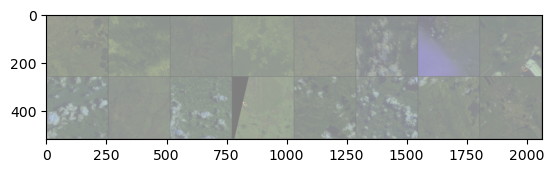

In [58]:
from albumentations.pytorch import ToTensorV2
import albumentations as alb
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import cv2

def init_kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data)
        if m.bias != None:
            nn.init.constant_(m.bias.data, 0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = alb.Compose([
    alb.HorizontalFlip(p = 0.5),
    alb.VerticalFlip(p = 0.5),
    alb.Rotate(limit = 90, p = 0.5, border_mode = cv2.BORDER_REPLICATE),
    ToTensorV2(transpose_mask = True)
])

dataSet = Spark(ROOT, train = True, transform = transform)

L = len(dataSet)
train_size = int(0.7 * L)
val_size = L - train_size
train_data, val_data = random_split(dataSet, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size = BATCH, shuffle = True)
val_loader = DataLoader(val_data, batch_size = BATCH, shuffle = True)

config_vit = CONFIGS["R50-ViT-B_16"]
config_vit.n_classes = 1
config_vit.patches.grid = (int(256 / 16), int(256 / 16))
model = VisionTransformer(config_vit, img_size = 256, num_classes = 1)
model = model.to(device)
model.apply(init_kaiming)
optim = torch.optim.Adam(model.parameters(), lr = 0.01)

lr_lambda = lambda epoch: math.exp(-1 * (math.sin(10 * epoch * math.pi / 180) ** 2) * math.sqrt(epoch))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optim, lr_lambda = lr_lambda)

loss = BCEIoULoss(0.5)
eval_metric = IoU(0.5)

trainer = Trainer(
    model = model,
    optimizer = optim,
    loss_func = loss,
    eval_metric = eval_metric,
    device = device,
    scheduler = scheduler,
    log_dir = "runs",
    epoch = EPOCH,
    batch = BATCH,
    seed = 0
)

trainer.run(train_loader, val_loader)